### Combination of Pharmacokinetics and Pharmacodynamics Modeling 

Updated: 240206

I combined the pharmacokinetics and pharmacodynamics model from data from the dosage curve and the tracking of the concetrations over time. 

$$\frac{dSc}{dt} = -k_{sb} Sc $$
$$\frac{dB}{dt} = k_{sb}Sc - k_{bp} B + k_{pb} P - k_{e} B $$
$$\frac{dP}{dt} = k_{bp} B - k_{pb} P $$
$$ Activity = \frac{1}{1 + 10^{-log_{10}(B)-(log_{10}(EC_{50}))}}$$

I used this model to determine experimental dosage regimes to potentially test out.
This notebook contains the code for the repeated dosing experiments

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy import optimize
import sys
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import auc

import pylab
import matplotlib.ticker as tck
## Define Context for Sizes
sns.set(font='Helvetica Neue',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'k',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'k',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'k',
 'xtick.bottom': True,
 'xtick.minor.visible': True,
 'xtick.color': 'k',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.minor.visible': True,
 'ytick.color': 'k',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})

sns.set_context("paper", rc={"font.size":12,
                             "axes.titlesize":16,
                             "axes.labelsize":16,
                             "xtick.labelsize":14,
                             "ytick.labelsize":14,
                            },font_scale=2)


import matplotlib.ticker as ticker

def apply_log_scale_with_custom_ticks(ax):
    """Apply log scale and custom tick settings to the given axes."""
    # Set major locator
    x_major = ticker.LogLocator(base=10.0, numticks=10)
    ax.xaxis.set_major_locator(x_major)
    
    # Set minor locator without labels
    x_minor = ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())



## Data File Location:
working_path = '/Users/qiuwu/Dropbox (HMS)/Important Documents in Graduate School/Shared_Qiu/FC Fusion Paper/'

save_figures_path = "/Figures/raw_figures/figure 4/"


### Data Input

## Define PK and PD Model

In [41]:
def PK_Model(t, z, ksb, kbp, kpb, ke1):
    sc, b, p = z
    dScdt = -ksb * sc 
    dBdt = ksb * sc - kbp * b + kpb * p - ke1 * b
    dPdt = kbp * b - kpb * p
    return [dScdt, dBdt, dPdt]

def Activity(x,ec50):
    y = 1 / (1 + 10**(-1*(x-ec50)))
    return y

## Set optimized Parameters

In [42]:
IL17_params = [0.01153685,0.00643526,0.00540588,0.0265443]
IL17_ec50 = np.log10(0.88)

FC_params = [0.00284224, 0.00024633, 0.00065471, 0.00125055] 
FC_ec50 = np.log10(2.57)

### PLOT FC IL-17 and IL-17 TOGETHER WITH MODEL

In order to test out experimental dosing regimes - I wrote a function to collect all solutions from the model as well as a function to inputting repeat regimes.

In [43]:
def repeated_dose_model(n_repeats, 
                        repeat_interval_time,  ## In Minutes
                        repeat_dose, 
                        model_params, 
                        InitialConditions):
    from scipy.integrate import solve_ivp
    ## Set up the solution recorder
    sc_soln = np.array([])
    bd_soln = np.array([])
    p_soln = np.array([])
    
    Int = InitialConditions
    ## Run through repeats
    for repeat in range(n_repeats):
        t_span = [0, repeat_interval_time]
        t_eval = np.linspace(t_span[0], t_span[1]-1, t_span[1])
        sc,b,p = solve_ivp(PK_Model, t_span, Int,
                           args=tuple(model_params), 
                           t_eval=t_eval, method='LSODA', atol=1e-8, rtol=1e-4).y
        ## Record each injection
        sc_soln= np.concatenate([sc_soln, sc])
        bd_soln= np.concatenate([bd_soln, b])
        p_soln= np.concatenate([p_soln, p])

        ## Set initialization parameters for the next injection
        Int = [sc_soln[-1]+repeat_dose, bd_soln[-1], p_soln[-1]]
    time_release = np.linspace(0,
                               n_repeats*repeat_interval_time, 
                               n_repeats*repeat_interval_time)
    return time_release, sc_soln, bd_soln, p_soln

In [44]:
dose = 5200
fc_dose= 4000
n_doses = 6

t,sc_il17,b_il17,p_il17 = repeated_dose_model(n_doses, 720, dose, IL17_params, [dose,0,0])
IL_activity = Activity(np.log10(b_il17/1000),IL17_ec50)

t,sc_fcil17,b_fcil17,p_fcil17 = repeated_dose_model(1, n_doses*720, fc_dose, FC_params, [fc_dose,0,0])
FC_activity = Activity(np.log10(b_fcil17/1000),FC_ec50)

/var/folders/6n/m295x70529xbnpr1vzrwnk1w0000gn/T/ipykernel_12800/406890403.py:6: RuntimeWarning: divide by zero encountered in log10
  IL_activity = Activity(np.log10(b_il17/1000),IL17_ec50)
/var/folders/6n/m295x70529xbnpr1vzrwnk1w0000gn/T/ipykernel_12800/406890403.py:9: RuntimeWarning: divide by zero encountered in log10
  FC_activity = Activity(np.log10(b_fcil17/1000),FC_ec50)


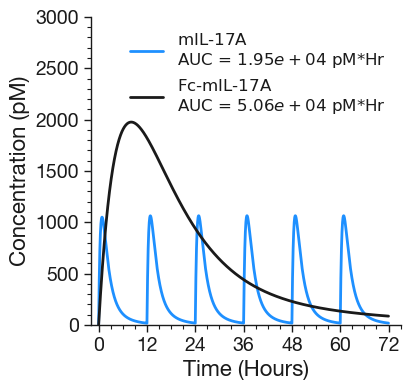

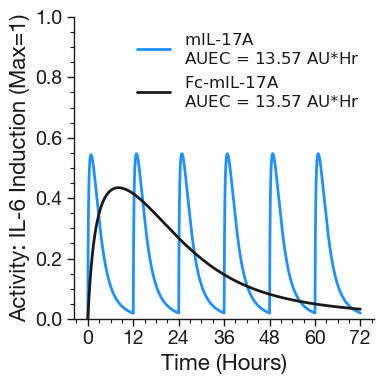

In [45]:
fig, ax1 = plt.subplots(figsize=(4,4))
il17_auc = f"{auc(t,b_il17)/60:.2e}" 
fcil17_auc = f"{auc(t,b_fcil17)/60:.2e}" 
ax1.plot(t/60, b_il17,
         label=rf'$\text{{mIL-17A}}$'+'\n'+rf'$\text{{AUC = }} {il17_auc} \text{{ pM*Hr}}$',
         color = 'dodgerblue', linestyle='-',linewidth=2)
ax1.plot(t/60, b_fcil17,
         label=rf'$\text{{Fc-mIL-17A}}$'+'\n'+rf'$\text{{AUC = }} {fcil17_auc} \text{{ pM*Hr}}$',
         color = 'k', linestyle='-',linewidth=2)

ax1.set_ylabel('Concentration (pM)')
ax1.set_xlabel('Time (Hours)')
ax1.legend(fontsize=12,frameon=False)
ax1.set_ylim([0,3000])
ax1.set_xlim([-2, 75])
ax1.set_xticks(np.arange(0,84,12))

plt.savefig(working_path+save_figures_path+ f"/Concentration_Dose_Regimen_With_legends.pdf",
            bbox_inches="tight",dpi=200)
fig, ax2 = plt.subplots(figsize=(4,4))
ax2.plot(t/60, IL_activity, 
        label=rf'$\text{{mIL-17A}}$'+'\n'+rf'$\text{{AUEC = }} {np.round(auc(t,IL_activity)/60,2)} \text{{ AU*Hr}}$',
         color = 'dodgerblue', 
         linestyle='-',linewidth=2,
        )

ax2.plot(t/60, FC_activity, 
         label=rf'$\text{{Fc-mIL-17A}}$'+'\n'+rf'$\text{{AUEC = }} {np.round(auc(t,FC_activity)/60,2)} \text{{ AU*Hr}}$',
         linewidth=2,
         linestyle='-', color = 'k')
ax2.set_ylabel('Activity: IL-6 Induction (Max=1)')
ax2.set_xlabel('Time (Hours)')
ax2.set_ylim(0,1)
ax1.set_xlim([-2, 75])

ax2.set_xticks(np.arange(0,84,12))
plt.tight_layout()
ax2.legend(fontsize=12,frameon=False)
plt.savefig(working_path+save_figures_path+ f"/PKPD_Dose_Regimen_With_legends.pdf",
            bbox_inches="tight",dpi=200)